In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [4]:
# Load data
de_train_path = '/content/drive/MyDrive/input_test/de_train.parquet'
de_train = pd.read_parquet(de_train_path)

In [6]:
print(de_train.shape)

(614, 18216)


In [7]:
# Define feature and label columns
features_columns = ["cell_type", "sm_name"]
labels_drop_columns = ["sm_lincs_id", "SMILES", "control"]
labels_drop_columns.extend(features_columns)

In [8]:
# Extract features and labels
features = pd.DataFrame(de_train, columns=features_columns)
smiles = de_train["SMILES"]
labels = de_train.drop(labels_drop_columns, axis=1)

# Extract cell types and sample names
cell_types = features.iloc[:, 0:1].values.ravel()
sn_names = features.iloc[:, 1:2].values.ravel()

In [9]:
# Create a dictionary to map sm_name to whether it is true or false based on SMILES column
groupby_sm_name_true_false = {v: 0 for v in sn_names}
for i, v in enumerate(smiles.values.ravel()):
    sm_name = sn_names[i]
    groupby_sm_name_true_false[sm_name] = v

# Map unique SMILES values to indices
map_smiles = {v: i for (i, v) in enumerate(smiles.unique())}
for v, s in groupby_sm_name_true_false.items():
    groupby_sm_name_true_false[v] = map_smiles[s]

# Print the results for verification
print("Features:")
print(features.head())
print("\nLabels:")
print(labels.head())
print("\nGroupby_sm_name_true_false:")
print(groupby_sm_name_true_false)

Features:
            cell_type             sm_name
0            NK cells        Clotrimazole
1        T cells CD4+        Clotrimazole
2        T cells CD8+        Clotrimazole
3  T regulatory cells        Clotrimazole
4            NK cells  Mometasone Furoate

Labels:
       A1BG  A1BG-AS1       A2M   A2M-AS1     A2MP1    A4GALT      AAAS  \
0  0.104720 -0.077524 -1.625596 -0.144545  0.143555  0.073229 -0.016823   
1  0.915953 -0.884380  0.371834 -0.081677 -0.498266  0.203559  0.604656   
2 -0.387721 -0.305378  0.567777  0.303895 -0.022653 -0.480681  0.467144   
3  0.232893  0.129029  0.336897  0.486946  0.767661  0.718590 -0.162145   
4  4.290652 -0.063864 -0.017443 -0.541154  0.570982  2.022829  0.600011   

       AACS     AAGAB      AAK1  ...      ZUP1      ZW10    ZWILCH     ZWINT  \
0  0.101717 -0.005153  1.043629  ... -0.227781 -0.010752 -0.023881  0.674536   
1  0.498592 -0.317184  0.375550  ... -0.494985 -0.303419  0.304955 -0.333905   
2 -0.293205 -0.005098  0.214918  ... -

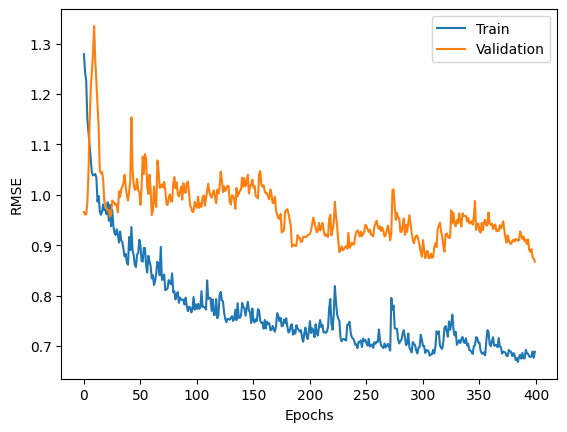

Fold score: 0.8674403429031372


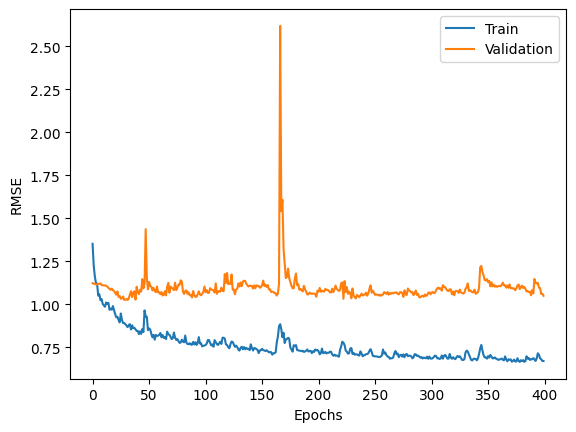

Fold score: 1.025517463684082


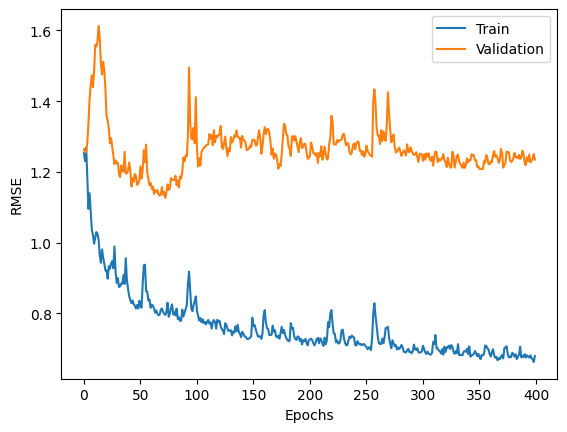

Fold score: 1.126347303390503


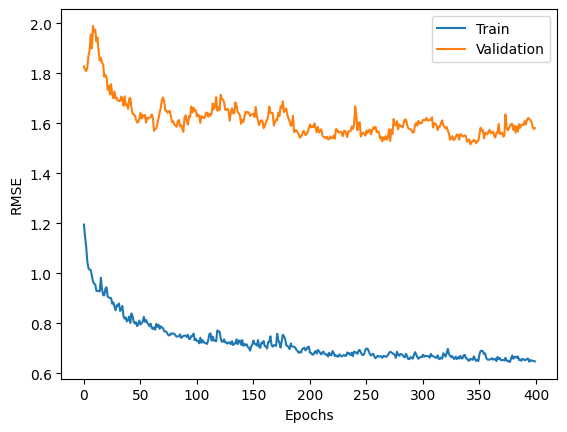

Fold score: 1.5165472030639648


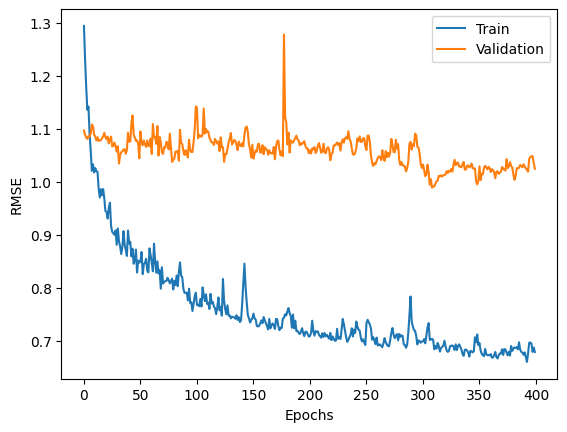

Fold score: 0.9889929294586182


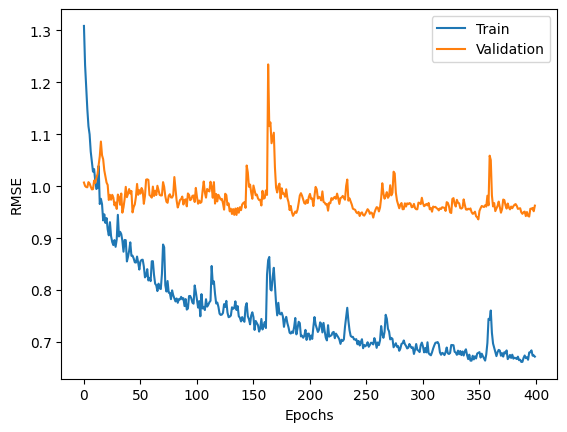

Fold score: 0.9360581636428833


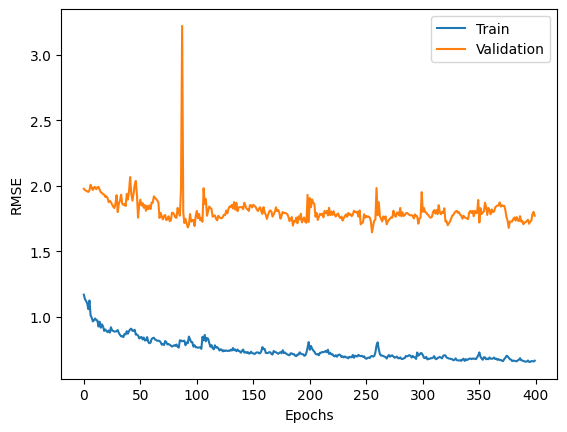

Fold score: 1.6448538303375244


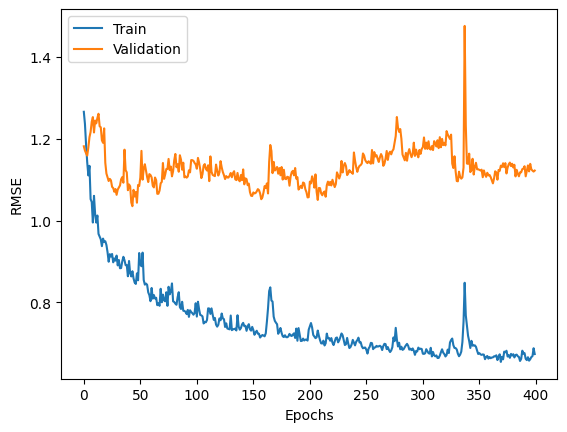

Fold score: 1.0350302457809448


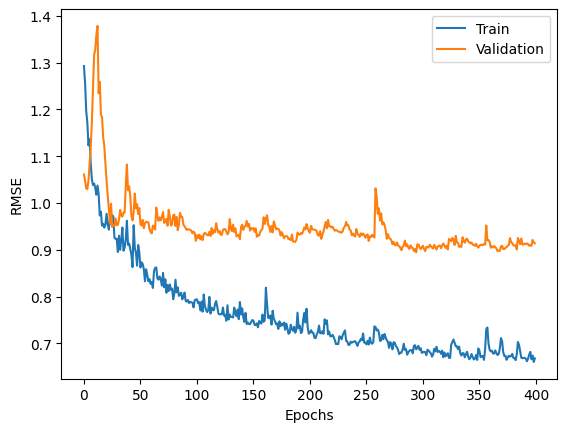

Fold score: 0.8948179483413696


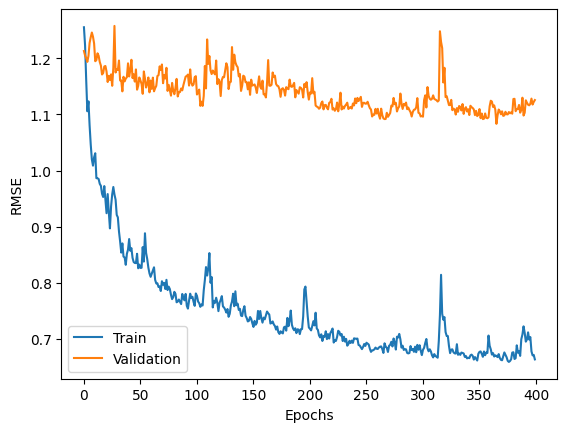

Fold score: 1.0833408832550049
Best score: 0.8674403429031372
Model version with best score: 0


In [11]:
# Helper functions for one-hot encoding
def map_to_categorical(map_data, data):
    copy_data = np.array(data, copy=True)
    for i in range(len(data)):
        copy_data[i] = map_data[copy_data[i]]
    return keras.utils.to_categorical(copy_data.ravel(), num_classes=len(map_data.values()))

unique_cell_types = np.unique(cell_types)
unique_sm_names = np.unique(sn_names)

map_cell_types = {v: i for (i, v) in enumerate(unique_cell_types)}
map_sm_names = {v: i for (i, v) in enumerate(unique_sm_names)}

one_hot_cell_types = map_to_categorical(map_cell_types, cell_types)
one_hot_sm_names = map_to_categorical(map_sm_names, sn_names)

one_hotted_features = []
for i in range(len(one_hot_sm_names)):
    joined = []
    joined.extend(one_hot_cell_types[i])
    joined.extend(one_hot_sm_names[i])
    onehot = keras.utils.to_categorical(groupby_sm_name_true_false[sn_names[i]], num_classes=len(unique_sm_names))
    joined.extend([v for v in onehot])
    one_hotted_features.append(joined)

X = np.array(one_hotted_features)
Y = labels

def plot_history(history):
    plt.plot(history["mean_rowwise_rmse"], label="Train")
    plt.plot(history["val_mean_rowwise_rmse"], label="Validation")
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

def mean_rowwise_rmse(y_true, y_pred):
    rmse_per_row = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    return tf.reduce_mean(rmse_per_row)

def create_model():
    return keras.Sequential([
        keras.layers.Dense(512, input_shape=(len(X[0]),), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(len(labels.values[0]), activation='linear')
    ])

model_version = 0
scores = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y.values[train_index], Y.values[test_index]

    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[mean_rowwise_rmse]
    )

    epochs = 400
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_rowwise_rmse',
        patience=20,
        restore_best_weights=True
    )

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"model{model_version}.ckpt",
        save_weights_only=True,
        monitor="val_mean_rowwise_rmse",
        mode="min",
        save_best_only=True,
        verbose=0
    )

    model_version += 1
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=32,
        verbose=0,
        validation_data=(x_test, y_test),
        #callbacks=[checkpoint, early_stopping]
    )

    plot_history(history.history)
    scores.append(min(history.history['val_mean_rowwise_rmse']))
    print(f"Fold score: {min(history.history['val_mean_rowwise_rmse'])}")

print(f"Best score: {np.min(scores)}")
print(f"Model version with best score: {np.argmin(scores)}")


In [12]:
model.load_weights("model3.ckpt")

print(mean_rowwise_rmse(Y.values,model.predict(X)))

20/20 [==============================] - 0s 9ms/step
tf.Tensor(0.8520577298525033, shape=(), dtype=float64)


In [13]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.002)


clf.fit(x_train, y_train)


results=clf.predict(x_test)

print(mean_rowwise_rmse(y_test,results),tf.losses.MeanAbsoluteError()(y_test,results))

tf.Tensor(1.1175205502993741, shape=(), dtype=float64) tf.Tensor(0.7835862, shape=(), dtype=float32)


In [14]:
from sklearn.ensemble import RandomForestRegressor


regr = RandomForestRegressor(max_depth=13, random_state=0)

regr.fit(x_train, y_train)
pred_random_forest=regr.predict(x_test);
print(mean_rowwise_rmse(y_test,pred_random_forest),tf.losses.MeanAbsoluteError()(y_test,pred_random_forest))

tf.Tensor(1.116528378504608, shape=(), dtype=float64) tf.Tensor(0.740659002457437, shape=(), dtype=float64)


In [15]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
linear = LinearSVR(epsilon=0.1, max_iter=20000)
linear_regs=MultiOutputRegressor(linear)
linear_regs.fit(x_train, y_train)
pred_linear_svr=linear_regs.predict(x_test);
print(mean_rowwise_rmse(y_test,pred_linear_svr),tf.losses.MeanAbsoluteError()(y_test,pred_linear_svr))

tf.Tensor(1.15216822424967, shape=(), dtype=float64) tf.Tensor(0.7771991840174969, shape=(), dtype=float64)
